In [57]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

__file__ = Path(os.path.realpath("__file__"))
project_path = __file__.parent
dataset_path = Path("/media/shaneoh/4T/dataset/celeba")

In [58]:
from collections import namedtuple
import csv
import PIL
from typing import Any, Callable, List, Optional, Union, Tuple

CSV = namedtuple("CSV", ["header", "index", "data"])


class CelebA(Dataset):
    """`Large-scale CelebFaces Attributes (CelebA) Dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        split (string): One of {'train', 'valid', 'test', 'all'}.
            Accordingly dataset is selected.
        target_type (string or list, optional): Type of target to use, ``attr``, ``identity``, ``bbox``,
            or ``landmarks``. Can also be a list to output a tuple with all specified target types.
            The targets represent:

                - ``attr`` (np.array shape=(40,) dtype=int): binary (0, 1) labels for attributes
                - ``identity`` (int): label for each person (data points with the same identity are the same person)
                - ``bbox`` (np.array shape=(4,) dtype=int): bounding box (x, y, width, height)
                - ``landmarks`` (np.array shape=(10,) dtype=int): landmark points (lefteye_x, lefteye_y, righteye_x,
                  righteye_y, nose_x, nose_y, leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y)

            Defaults to ``attr``. If empty, ``None`` will be returned as target.

        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """

    base_folder = "celeba"

    def __init__(
            self,
            dataset_path,
            split = "train",
            target_type = ["attr"],
            transform = None,
            target_transform = None,
    ) -> None:
        self.split = split
        split_map = {
            "train": 0,
            "valid": 1,
            "test": 2,
            "all": None,
        }
        
        self.target_type = target_type
        self.transform = transform
        self.target_transform = target_transform
        
        dataset_path = Path(dataset_path)
        if not dataset_path.exists():
            raise RuntimeError("dataset path does not exist")
        self.dataset_path = dataset_path
        
        split_ = split_map[split.lower()]
        splits = self._load_csv(self.dataset_path / "Eval" / "list_eval_partition.txt")
        identity = self._load_csv(self.dataset_path / "Anno" / "identity_CelebA.txt")
        attr = self._load_csv(self.dataset_path / "Anno" / "list_attr_celeba.txt", header=1)
        bbox = self._load_csv(self.dataset_path / "Anno" / "list_bbox_celeba.txt", header=1)
        landmarks = self._load_csv(self.dataset_path / "Anno" / "list_landmarks_celeba.txt", header=1)
        landmarks_align = self._load_csv(self.dataset_path / "Anno" / "list_landmarks_align_celeba.txt", header=1)

        mask = slice(None) if split_ is None else (splits.data == split_).squeeze()

        self.filename = splits.index
        self.identity = identity.data[mask]
        self.bbox = bbox.data[mask]
        self.landmarks_align = landmarks_align.data[mask]
        self.attr = attr.data[mask]
        # map from {-1, 1} to {0, 1}
        self.attr = torch.div(self.attr + 1, 2, rounding_mode='floor')
        self.attr_names = attr.header

    def _load_csv(
        self,
        filename,
        header: Optional[int] = None,
    ) -> CSV:
        data, indices, headers = [], [], []

        with open(filename) as csv_file:
            data = list(csv.reader(csv_file, delimiter=' ', skipinitialspace=True))

        if header is not None:
            headers = data[header]
            data = data[header + 1:]

        indices = [row[0] for row in data]
        data = [row[1:] for row in data]
        data_int = [list(map(int, i)) for i in data]

        return CSV(headers, indices, torch.tensor(data_int))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        X = PIL.Image.open(self.dataset_path / "Img" / "img_align_celeba_png.7z" / str(self.filename[index].split(".")[0] + ".png"))

        target: Any = []
        for t in self.target_type:
            if t == "attr":
                target.append(self.attr[index, :])
            elif t == "identity":
                target.append(self.identity[index, 0])
            elif t == "bbox":
                target.append(self.bbox[index, :])
            elif t == "landmarks":
                target.append(self.landmarks_align[index, :])
            else:
                # TODO: refactor with utils.verify_str_arg
                raise ValueError("Target type \"{}\" is not recognized.".format(t))

        if self.transform is not None:
            X = self.transform(X)

        if target:
            target = tuple(target) if len(target) > 1 else target[0]

            if self.target_transform is not None:
                target = self.target_transform(target)
        else:
            target = None

        return X, target

    def __len__(self) -> int:
        return len(self.attr)

    def extra_repr(self) -> str:
        lines = ["Target type: {target_type}", "Split: {split}"]
        return '\n'.join(lines).format(**self.__dict__)

In [88]:
attr = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
attr_list = attr.split(" ")

for i, attr in enumerate(attr_list):
    if attr in ["Smiling"]:
        print(f"{i:>2} {attr}")

31 Smiling


In [67]:
BATCH_SIZE = 64

transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor()])

# train_data = CelebA(dataset_path=dataset_path, split="train", target_type=["attr"], transform=ToTensor())
# valid_data = CelebA(dataset_path=dataset_path, split="valid", target_type=["attr"], transform=ToTensor())
# test_data  = CelebA(dataset_path=dataset_path, split="test",  target_type=["attr"], transform=ToTensor())

train_data = CelebA(dataset_path=dataset_path, split="train", target_type=["attr"], transform=transform)
valid_data = CelebA(dataset_path=dataset_path, split="valid", target_type=["attr"], transform=transform)
test_data  = CelebA(dataset_path=dataset_path, split="test",  target_type=["attr"], transform=transform)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=True)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64, 40])


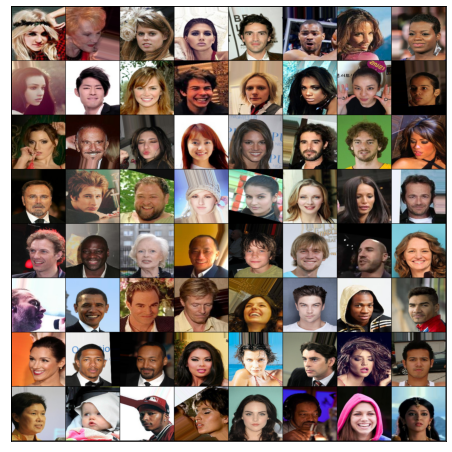

In [68]:
from torchvision.utils import make_grid

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

import matplotlib.pyplot as plt
import numpy as np

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[0].detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

show_batch(train_dataloader)

In [ ]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print('Using {} device'.format(device))

# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model.eval()

# input_batch, train_labels = next(iter(train_dataloader))
# with torch.no_grad():
#     output = model(input_batch)
# # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# # print(output[0])
# # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
# probabilities = torch.nn.functional.softmax(output[0], dim=0)
# print(probabilities)

In [ ]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(train_dataloader))

# get the most likely prediction of the model
pred = vgg(img).argmax(dim=1)

In [ ]:
pred

tensor([903])